In [1]:
## Google's Generative AI search provided the initial draft of this code. 
## I have modified it since. 
## It provided these sources: 
## https://github.com/jk96491/RL_Algorithms?tab=readme-ov-file 
## https://github.com/abyaadrafid/Deep-Reinforcement-Learning 
## I couldn't find a draft of this code in the sources, 
## so Generative AI search may have generated the code. 

import random 
import numpy as np 
import gym
import torch
import torch.nn as nn
import torch.optim as optim 

torch.autograd.set_detect_anomaly(True) ## DEBUGGING 

class Object(object):
    pass

class ReplayBuffer(): 
    def __init__(self, capacity=10000): 
        self.n = 0 
        self.capacity = capacity 
        self.state_list = [] 
        self.action_list = [] 
        self.reward_list = [] 
        self.next_state_list = [] 
        self.done_list = [] 
        pass 
    def __len__(self):
         return self.n 
    def add(self, state, action, reward, next_state, done): 
        if self.n >= self.capacity: 
            ## discard earliest observation 
            self.state_list = self.state_list[1:] 
            self.action_list = self.action_list[1:] 
            self.reward_list = self.reward_list[1:] 
            self.next_state_list = self.next_state_list[1:] 
            self.done_list = self.done_list[1:] 
            self.n -= 1 
        pass 
        ## cast to torch  
        state = torch.tensor(state) 
        action = torch.tensor(action) 
        reward = torch.tensor(reward) 
        next_state = torch.tensor(next_state) 
        done = torch.tensor(done) 
        ## append to buffer 
        self.state_list.append(state) 
        self.action_list.append(action) 
        self.reward_list.append(reward) 
        self.next_state_list.append(next_state) 
        self.done_list.append(done) 
        self.n += 1 
        pass 
    def sample(self, batch_size=32): 
        ## sample lists 
        out = Object() ## transitions 
        out.state = [] 
        out.action = [] 
        out.reward = [] 
        out.next_state = [] 
        out.done = [] 
        for _ in range(batch_size): 
            idx = random.randint(0, self.n-1) 
            out.state.append(self.state_list[idx]) 
            out.action.append(self.action_list[idx]) 
            out.reward.append(self.reward_list[idx]) 
            out.next_state.append(self.next_state_list[idx]) 
            out.done.append(self.done_list[idx]) 
            pass 
        ## stack  
        out.state = torch.stack(out.state) 
        out.action = torch.stack(out.action) 
        out.reward = torch.stack(out.reward) 
        out.next_state = torch.stack(out.next_state) 
        out.done = torch.stack(out.done) 
        return out 
    pass 

# Define the actor and critic networks
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x))

        return action

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.fc3(x)

        return value

# Create the actor and critic networks
actor = Actor(state_dim=4, action_dim=1)
critic = Critic(state_dim=4, action_dim=1)

# Define the optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-5)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-5)

# Create the replay buffer
replay_buffer = ReplayBuffer(capacity=100000) 

# Define the environment
env = gym.make('CartPole-v1')

reward_list = [] 
p_list = [] # DEBUG 

# Train the agent
for episode in range(1000):
    state = env.reset()

    for t in range(1000):
        action = actor(torch.tensor(state)) 
        
        action_p = action.item() * .5 + .5 
        action_int = np.random.binomial(1, action_p) ## must be 0 or 1 
        next_state, reward, done, _ = env.step(action_int) 

        replay_buffer.add(state, action, reward, next_state, done)

        if len(replay_buffer) > 1000:
            # Sample a batch of transitions from the replay buffer
            transitions = replay_buffer.sample(batch_size=32)

            # Calculate the target Q-values
            target_Q = critic(transitions.next_state, actor(transitions.next_state))
            target_Q = target_Q.clone().detach() * .99 + transitions.reward 

            # Calculate the current Q-values
            current_Q = critic(transitions.state, transitions.action)

            # Calculate the critic loss
            critic_loss = torch.mean((target_Q - current_Q).pow(2)) 

            # Update the critic network
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            
            if len(replay_buffer) > 2000:
                # Calculate the actor loss
                actor_loss = -torch.mean(critic(transitions.state, actor(transitions.state)))

                # Update the actor network
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

        state = next_state

        if done:
            break

    # Evaluate the agent
    episode_reward = 0 
    state = env.reset() 

    for t in range(1000): 
        action = actor(torch.tensor(state))

        action_p = action.item() * .5 + .5 
        action_int = np.random.binomial(1, action_p) ## must be 0 or 1
        next_state, reward, done, _ = env.step(action_int) 
        p_list.append(action_p) # DEBUG 

        episode_reward += reward

        if done:
            break
    
    reward_list.append(episode_reward)
    print('Episode {}: {}'.format(episode, episode_reward))

/tmp/ipykernel_4558/2074754709.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/astroid/node_classes.py:94: DeprecationWarning: The 'astroid.node_cla

Episode 0: 13.0
Episode 1: 34.0
Episode 2: 31.0
Episode 3: 10.0
Episode 4: 18.0
Episode 5: 34.0
Episode 6: 19.0
Episode 7: 31.0
Episode 8: 19.0
Episode 9: 28.0
Episode 10: 24.0
Episode 11: 40.0
Episode 12: 15.0
Episode 13: 16.0
Episode 14: 13.0
Episode 15: 21.0
Episode 16: 15.0
Episode 17: 13.0
Episode 18: 18.0
Episode 19: 12.0
Episode 20: 11.0
Episode 21: 11.0
Episode 22: 10.0
Episode 23: 29.0
Episode 24: 61.0
Episode 25: 43.0
Episode 26: 24.0
Episode 27: 10.0
Episode 28: 19.0
Episode 29: 20.0
Episode 30: 9.0
Episode 31: 22.0
Episode 32: 27.0
Episode 33: 26.0
Episode 34: 12.0
Episode 35: 35.0
Episode 36: 37.0
Episode 37: 13.0
Episode 38: 19.0
Episode 39: 16.0
Episode 40: 48.0
Episode 41: 14.0
Episode 42: 11.0
Episode 43: 15.0
Episode 44: 18.0
Episode 45: 50.0
Episode 46: 16.0
Episode 47: 15.0
Episode 48: 69.0
Episode 49: 14.0
Episode 50: 9.0
Episode 51: 12.0
Episode 52: 29.0
Episode 53: 9.0
Episode 54: 12.0
Episode 55: 26.0
Episode 56: 51.0
Episode 57: 15.0
Episode 58: 12.0
Episode 59

KeyboardInterrupt: 

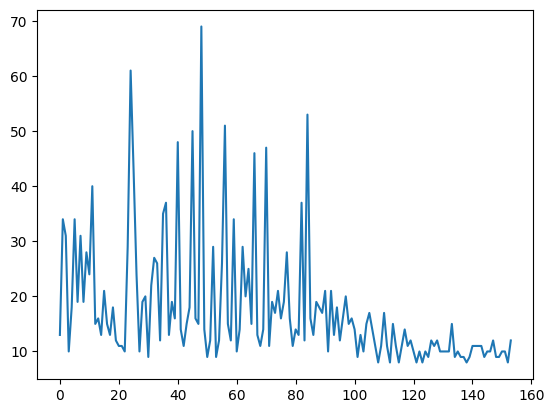

In [2]:
import matplotlib.pyplot as plt


plt.plot(reward_list)
plt.show()

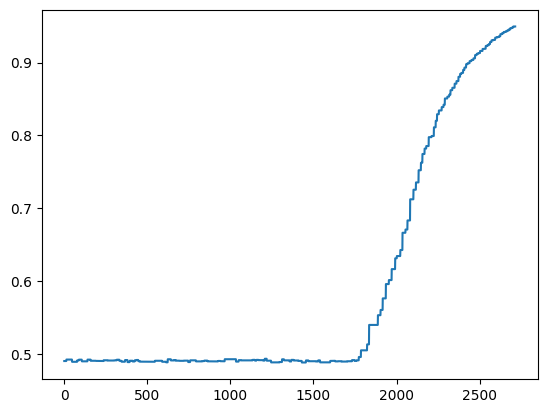

In [3]:
import matplotlib.pyplot as plt


plt.plot(p_list)
plt.show()